In [1]:
import numpy as np

In [98]:
class KMeans():
    def __init__(self):
        self.centroids = []
        self.distance_function = None
        self.max_iterations = 0
        self.max_error = 0
    
    def initialize_random(self, centroid_number, data):
        data_count, dimensions = data.shape
        selected_rows = np.random.randint(0, data_count, centroid_number)
        self.centroids = data[selected_rows]
        return self
        
    def initialize_plus_plus(self, centroid_number, data):
        data_count, dimensions = data.shape
        self.centroids = [data[np.random.randint(0, data_count)]]
        
        for _ in range(centroid_number - 1):
            squared_distances_to_bmus = np.array([self.distance_function(x - self.get_bmu(x)[1]) ** 2 for x in data])
            probabilities = squared_distances_to_bmus / squared_distances_to_bmus.sum()
            probabilites_accumulated = probabilities.cumsum()
            
            r = np.random.random()
            ind = np.where(probabilites_accumulated >= r)[0][0]
            self.centroids.append(data[ind])
        return self

    def with_euclidian_distance(self):
        self.distance_function = np.linalg.norm
        return self
    
    def set_max_iterations(self, iterations):
        self.max_iterations = iterations
        return self
    
    def set_max_error(self, error):
        self.max_error = error
        return self

    def train(self, X):
        
        finished = False
        current_iteration = 0
        while not finished:
            error = self.fit(X)
            current_iteration += 1
            if self.max_iterations > 0 and current_iteration > self.max_iterations:
                finished = True

            if error <= self.max_error:
                finished = True

        return self, current_iteration
    
    def predict(self, x):
        group_id, bmu = self.get_bmu(x)
        return group_id, bmu

    def get_bmu(self, x):
        bmu_id, bmu, bmu_dist = 0, self.centroids[0], self.distance_function(self.centroids[0] - x)
        for i, c in enumerate(self.centroids[1:], 1):
            c_dist = self.distance_function(c - x)
            if c_dist < bmu_dist:
                bmu_id, bmu, bmu_dist = i, c, c_dist
        return bmu_id, bmu

    def fit(self, X):
        groups = [[] for i in self.centroids]
        for x in X:
            bmu_id, _ = self.get_bmu(x)
            groups[bmu_id].append(x)
        
        error = 0
        for group_id, _ in enumerate(groups):
            group_mean = np.mean(groups[group_id], 0) if len(groups[group_id]) > 0 else None
            if group_mean is not None:
                error += self.distance_function(self.centroids[group_id] - group_mean)
                self.centroids[group_id] = group_mean
        return error

In [3]:
def read_data(path):
    x = np.genfromtxt(path, delimiter=',', skip_header=1)
    x = np.delete(x, 0, axis=1)
    return x

In [4]:
data = read_data('data/bbc/BsaidaBin98.csv')
data.shape

(737, 1369)

## Toy datasets

Trained in  6 iterations


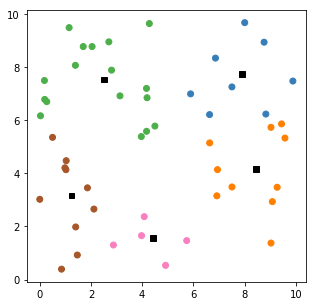

In [102]:
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from itertools import cycle, islice
%matplotlib inline
np.random.seed(1)
#blobs = datasets.make_blobs(n_samples=50, centers=5, random_state=20)
blobs = np.random.random((50, 2)) * 10, 1
fig = plt.figure(figsize=(5, 5))

X, y = blobs

kmeans, iterations = KMeans() \
            .initialize_random(5, X) \
            .with_euclidian_distance() \
            .train(X)
            
print('Trained in ', iterations, 'iterations')
    
predictions = [kmeans.predict(x) for x in X]
y_pred = [y for y, _ in predictions]

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))

plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred])
for i, centroid in enumerate(kmeans.centroids):
    square = plt.Rectangle(centroid, 0.21, 0.2, color='black')
    fig.gca().add_artist(square)

plt.show()

Trained in  4 iterations


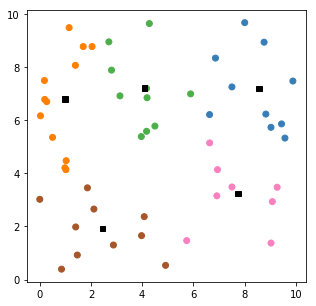

In [101]:
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from itertools import cycle, islice
%matplotlib inline
np.random.seed(1)

#blobs = datasets.make_blobs(n_samples=50, centers=5, random_state=20)
blobs = np.random.random((50, 2)) * 10, 1
fig = plt.figure(figsize=(5, 5))

X, y = blobs

kmeans, iterations = KMeans() \
            .with_euclidian_distance() \
            .initialize_plus_plus(5, X) \
            .train(X)
            
print('Trained in ', iterations, 'iterations')
    
predictions = [kmeans.predict(x) for x in X]
y_pred = [y for y, _ in predictions]

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))

plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred])
for i, centroid in enumerate(kmeans.centroids):
    square = plt.Rectangle(centroid, 0.21, 0.2, color='black')
    fig.gca().add_artist(square)

plt.show()